In [14]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [15]:
df_train = pd.read_csv('/kaggle/input/nli-dataset-for-sentence-understanding/mnli_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/kaggle/input/nli-dataset-for-sentence-understanding/mnli_test_matched.csv')
df_val= pd.read_csv('/kaggle/input/nli-dataset-for-sentence-understanding/mnli_validation_matched.csv')

In [16]:
df_train.head()

,premise,hypothesis,label,idx
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,0
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,1
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,2
3,How do you know? All this is their information...,This information belongs to them.,0,3
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,4


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392702 entries, 0 to 392701
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   premise     392702 non-null  object
 1   hypothesis  392662 non-null  object
 2   label       392702 non-null  int64 
 3   idx         392702 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 12.0+ MB


In [18]:
df_val.head()

,premise,hypothesis,label,idx
0,The new rights are nice enough,Everyone really likes the newest benefits,1,0
1,This site includes a list of all award winners...,The Government Executive articles housed on th...,2,1
2,uh i don't know i i have mixed emotions about ...,"I like him for the most part, but would still ...",0,2
3,yeah i i think my favorite restaurant is alway...,My favorite restaurants are always at least a ...,2,3
4,i don't know um do you do a lot of camping,I know exactly.,2,4


In [19]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9815 entries, 0 to 9814
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     9815 non-null   object
 1   hypothesis  9815 non-null   object
 2   label       9815 non-null   int64 
 3   idx         9815 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 306.8+ KB


In [20]:
# Drop rows with any missing values in the 'hypothesis' column
df_train.dropna(subset=['hypothesis'], inplace=True)
# No missing values were reported in df_test and df_val, but it's good practice to check
df_test.dropna(subset=['hypothesis'], inplace=True)
df_val.dropna(subset=['hypothesis'], inplace=True)

In [21]:
import re

def clean_text(text):
    """Cleans the input text by removing extra spaces."""
    # Trim leading and trailing white spaces
    text = text.strip()
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply the cleaning function to the 'premise' and 'hypothesis' columns of your datasets
df_train['premise'] = df_train['premise'].apply(clean_text)
df_train['hypothesis'] = df_train['hypothesis'].apply(clean_text)

df_test['premise'] = df_test['premise'].apply(clean_text)
df_test['hypothesis'] = df_test['hypothesis'].apply(clean_text)

df_val['premise'] = df_val['premise'].apply(clean_text)
df_val['hypothesis'] = df_val['hypothesis'].apply(clean_text)

In [22]:
from transformers import DebertaV2Tokenizer

tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")


In [23]:
# Example of concatenating and then tokenizing
def tokenize_texts(premises, hypotheses):
    token_lengths = []
    for premise, hypothesis in zip(premises, hypotheses):
        # Concatenating premise and hypothesis
        combined_text = premise + " [SEP] " + hypothesis
        # Tokenizing
        tokens = tokenizer.encode(combined_text, add_special_tokens=True)
        # Append the length
        token_lengths.append(len(tokens))
    return token_lengths

token_lengths_train = tokenize_texts(df_train['premise'].values, df_train['hypothesis'].values)


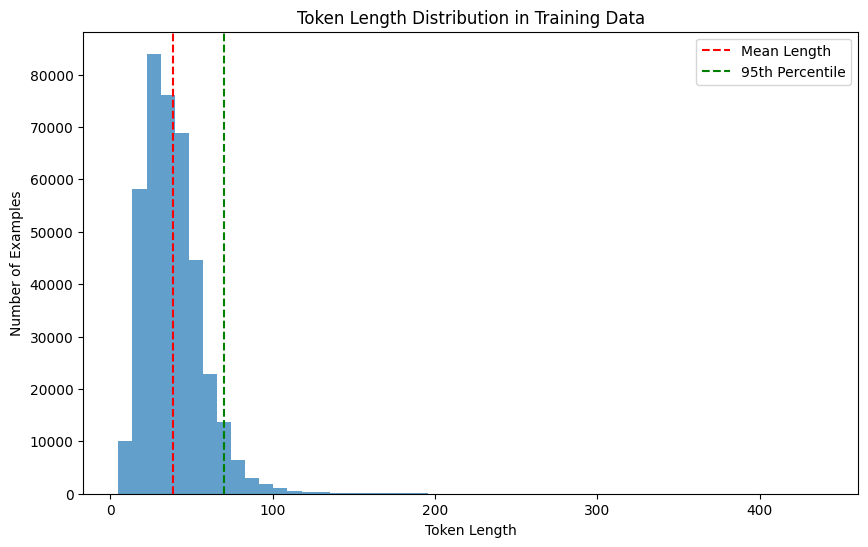

Mean token length: 38.783495729151284
95th percentile of token length: 70.0


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(token_lengths_train, bins=50, alpha=0.7)
plt.title('Token Length Distribution in Training Data')
plt.xlabel('Token Length')
plt.ylabel('Number of Examples')
plt.axvline(x=np.mean(token_lengths_train), color='r', linestyle='--', label='Mean Length')
plt.axvline(x=np.percentile(token_lengths_train, 95), color='g', linestyle='--', label='95th Percentile')
plt.legend()
plt.show()

print(f"Mean token length: {np.mean(token_lengths_train)}")
print(f"95th percentile of token length: {np.percentile(token_lengths_train, 95)}")


In [25]:
def get_max_token_length(premises, hypotheses):
    max_len = 0
    for premise, hypothesis in zip(premises, hypotheses):
        # Tokenize without truncation
        tokens = tokenizer.encode(premise, hypothesis, add_special_tokens=True)
        # Update max_len if current length is greater
        max_len = max(max_len, len(tokens))
    return max_len

# Assuming df_train, df_test, and df_val are your datasets
max_len_train = get_max_token_length(df_train['premise'].values, df_train['hypothesis'].values)
max_len_test = get_max_token_length(df_test['premise'].values, df_test['hypothesis'].values)
max_len_val = get_max_token_length(df_val['premise'].values, df_val['hypothesis'].values)

# Determine the overall maximum length
overall_max_len = max(max_len_train, max_len_test, max_len_val)

print(f"Maximum token length across the datasets: {overall_max_len}")


Maximum token length across the datasets: 439


In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DebertaV2Tokenizer, DebertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")

def prepare_dataset(sentences1, sentences2, labels, max_length=439):
    input_ids = []
    attention_masks = []

    for sent1, sent2 in zip(sentences1, sentences2):
        encoded_dict = tokenizer.encode_plus(
            sent1, sent2,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return TensorDataset(input_ids, attention_masks, labels)

# Assuming df_train, df_test, and df_val are already loaded and processed
train_dataset = prepare_dataset(df_train['premise'], df_train['hypothesis'], df_train['label'].values)
val_dataset = prepare_dataset(df_val['premise'], df_val['hypothesis'], df_val['label'].values)

In [27]:
batch_size = 16  # Adjust based on the available GPU memory

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)


In [31]:
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
import torch

# Load the tokenizer
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")

# Load the model
model = DebertaV2ForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-large",
    num_labels=3,  # Specifying the number of labels for the MNLI task
    output_attentions=False,
    output_hidden_states=False,
)

    
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the defined device
model.to(device)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, element

In [32]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

epochs = 3  # Adjust based on your needs
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


In [36]:
import os
import torch
from torch.cuda.amp import GradScaler, autocast

# Define paths and variables
checkpoint_dir = '/kaggle/working/'
os.makedirs(checkpoint_dir, exist_ok=True)
best_val_loss = float('inf')
scaler = GradScaler()
accumulation_steps = 4  # Adjust based on your specific requirements

# Assume 'epochs', 'model', 'optimizer', 'scheduler', 'train_dataloader', and 'validation_dataloader' are defined

def compute_validation_loss(validation_dataloader, model, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            with autocast():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss.item()
            total_loss += loss
    return total_loss / len(validation_dataloader)

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(train_dataloader, 1):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with autocast():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if step % accumulation_steps == 0 or step == len(train_dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_train_loss += loss.item() * accumulation_steps  # Undo the division to get the total loss

    avg_train_loss = total_train_loss / len(train_dataloader)
    val_loss = compute_validation_loss(validation_dataloader, model, device)

    print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_train_loss} | Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = os.path.join(checkpoint_dir, 'best_model.bin')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'training_loss': avg_train_loss,
            'validation_loss': val_loss,
        }, checkpoint_path)

        print(f"Best model saved to {checkpoint_path}")

# Function to load a checkpoint
def load_checkpoint(model, optimizer, scheduler, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return checkpoint['epoch'], checkpoint['training_loss'], checkpoint['validation_loss']

# Example of loading a model
checkpoint_path = '/kaggle/working/best_model.bin'
epoch, training_loss, validation_loss = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
print(f"Loaded model from epoch {epoch} with training loss {training_loss} and validation loss {validation_loss}.")


OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 23.06 MiB is free. Process 2414 has 14.72 GiB memory in use. Of the allocated memory 14.13 GiB is allocated by PyTorch, and 479.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF